# The irriducible mass of black holes

For a BH of mass $M$ spin $\chi\in [0,1]$, the irreducible mass is 
\begin{equation}
M_{\rm irr} = %\sqrt{\frac{M^2+\sqrt{M^4-S^2}}{2}} = 
 M \sqrt{\frac{1+\sqrt{1-\chi^2}}{2}}
\label{mirrdef}
\end{equation}
For convenience, let us define $f= M_{\rm irr}/M$

Suppose you have repeated measurment of $M$ and $\chi$. This is just because we're still frequentists for now. When we put our Bayesian hat on, these distributions will be the *posterior samples* from a single measurement.

Let's assume that

- the spin $\chi$ is uniformly distributed between 0 and 1.
- the mass $M$ is normally distributed with mean $\mu$ and standard deviation $\sigma$.

These are simplistic assumption that, however, are not too far from what we are now measuring with gravitational-wave detectors. It's a toy model, but not a totally unreasonable one.

**Tasks**:

1. Start with a value of $\sigma=0.02$. Note that $\mu$ is a scale and not a parameter: you can normalize all quantities with a dimension of mass by $\mu$. Just set $\mu=1$ in your code and remember that all masses in the problem are measured in units of $\mu$. 

2. Plot the resulting pdf of $M_{\rm irr}$. First try an histogram with one the rules of thumb we've seen above.

*Hint*: You don't know the functional form of the pdf of $M_{\rm irr}$... but you don't need it if you just want to generate samples! That's the nice thing about numerics!

3. Using the same samples, plot the $M_{\rm irr}$ using a KDE.

4. Compute the KS distance between ${M_{\rm irr}}$ and ${f}$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$. 

5. Compute the KS distance between ${M_{\rm irr}}$ and $M$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$.

6. You should find that (i) $M_{\rm irr}$ is distributed like $f$ if ${\sigma}\ll \mu$ and (ii) $M_{\rm irr}$ is distributed like $M$ if  $\sigma\gg \mu$.


7. (At home...)  Compute the pdfs of $M_{\rm irr}$ from their mathematical definitions, plot them, and check they agree with your KDE.

*Hint 1*: First compute the pdf of $f$, that is just a change of variable. We saw how to do this in a previous lecture. The answer is:
\begin{equation}
\pi(f) = 2\frac{2 f^2-1}{\sqrt{1 - f^2}}\,.
\end{equation}

*Hint 2*: Then compute the pdf of $M_{\rm irr}$, you want to use [this theorem](https://en.wikipedia.org/wiki/Distribution_of_the_product_of_two_random_variables) for the product of two random variables. The answer is only semi-analytic (unless you know how to solve that integral? If yes please tell me!)
\begin{equation}
p(M_{\rm irr})  = \frac{\sqrt{2/\pi}}{\sigma} \int_{1/\sqrt{2}}^1 \exp\left[{-\frac{(M_{\rm irr}/f -\mu)^2}{2\sigma^2}}\right]  \frac{2 f^2-1}{f \sqrt{1 - f^2}}  \,\, {\rm d}f\,. \label{pmirr}
\end{equation}



In [1]:
import numpy as np
from matplotlib import pyplot as plt
#%matplotlib inline
#%config InlineBackend.figure_format='retina'

from scipy.integrate import quad
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import uniform
import scipy.stats
from scipy import optimize
from astroML import stats as astroMLstats
from astropy.visualization.hist import hist as fancyhist
from sklearn.neighbors import KernelDensity
from tqdm.auto import tqdm

I generate the distributions for the mass and the spin, than I check the correctness.

Text(0.5, 1.0, 'uniform distribution of $\\chi$')

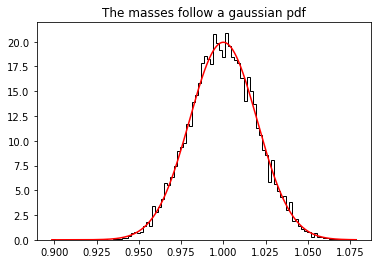

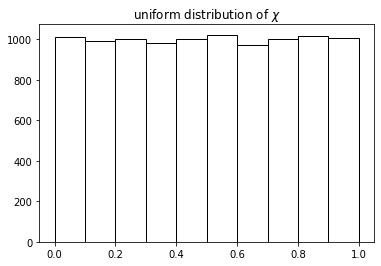

In [2]:
N=10000
chi = np.random.uniform(0,1,N)
mass = np.random.normal(loc=1, scale=0.02,size=N) # mean is a scale not a number, all is in units of this

# check the mass distribution is gaussian
plt.figure()
x_grid=np.linspace(np.min(mass),np.max(mass),N)
plt.hist(mass,bins=100,density=True, histtype='step', color='black')
plt.plot(x_grid, norm(loc=1,scale=0.02).pdf(x_grid), '-', c='red')
plt.title('The masses follow a gaussian pdf')

# check the chi distribution is uniform
plt.figure()
# xg = np.linspace(0,1,N)
plt.hist(chi,color='black', fill=False)
plt.title('uniform distribution of $\chi$')

Le me define the irriducible mass as function of chi and M

Text(0, 0.5, 'f')

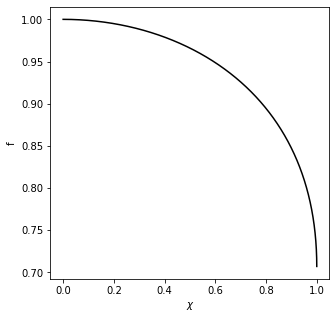

In [3]:
def M_irr(x,y):
    return x*np.sqrt((1+np.sqrt(1-y**2))/(2))

def f(x):
    return M_irr(mass,chi)/x

f=f(mass)

# check the f(chi) ditribution

xx = np.linspace(0,1,N)
plt.figure(figsize=[5,5])
plt.plot(xx,M_irr(mass,xx)/mass, c='black')
plt.xlabel('$\chi$')
plt.ylabel('f')

Let me make the istogram ignoring the fact I want a variable width for the bin. Also if there aren't significative difference (bimodaliy), the pdf are quite different.

<ipython-input-4-eec3f6ccdd97>:6: RuntimeWarning: divide by zero encountered in true_divide
  pdf_f = 2*(2*ff**2-1)/(1 - ff**2)**0.5 # hint from lecture's task


bins size from F-D rule is  0.007592665802111907


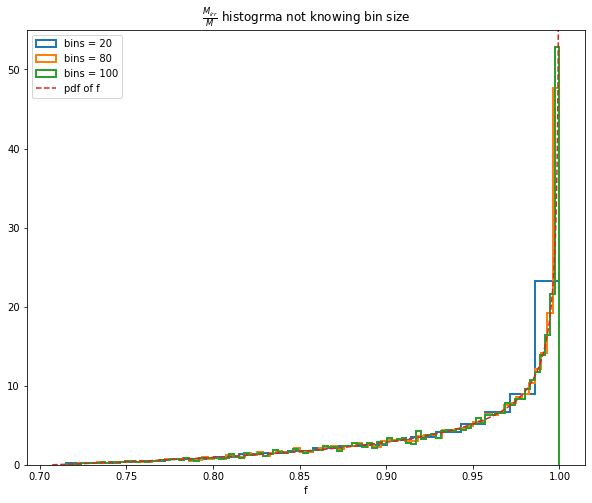

In [4]:
plt.figure(figsize=[10,8])
plt.title(r'$\frac{M_{irr}}{M}$ histogrma not knowing bin size')

bins=[20,80,100]
ff = np.linspace(1/2**0.5,1,N)
pdf_f = 2*(2*ff**2-1)/(1 - ff**2)**0.5 # hint from lecture's task

# histo with different binnings fitted by the PDF of f (=M_irr formula)

for i in range(len(bins)):
    plt.hist(f,bins=bins[i], density=True, histtype='step',lw=2, label='bins = %1.0f' % bins[i])
plt.plot(ff,pdf_f,'--',label='pdf of f')
plt.xlabel('f')
plt.ylim(0,55)
plt.legend(loc='best')

bin_size = 2.7*astroMLstats.sigmaG(f) / N**(1/3) # Friedman - Diaconis rule also if we know sigma
print('bins size from F-D rule is ', bin_size)

Let me use fancyhist to compute the variable-width of the bin "automatically" using scott and freedman-diaconis' rules. As expected the method works equally nice. I plot also a rug plot to underline the presence of empty bin.

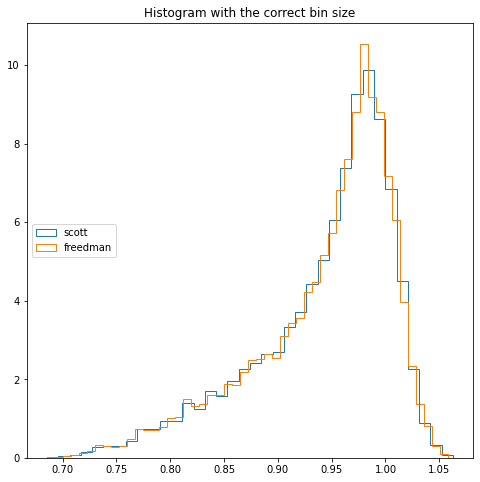

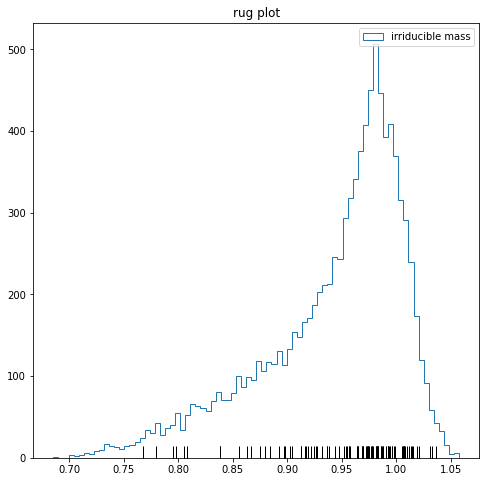

In [5]:
# plot the irriducible mass without normalization to m

xx=np.linspace(1-5*0.02,1+5*0.02,N)

plt.figure(figsize=[8,8])
plt.title('Histogram with the correct bin size')
_ = fancyhist(M_irr(mass,chi), bins="scott", histtype="step",density=True, label='scott') # f*norm.pdf(xx,1,0.02)
_ = fancyhist(M_irr(mass,chi), bins="freedman", histtype="step",density=True, label='freedman') # ‘freedman’ : use the Freedman-Diaconis rule to determine bins
#plt.hist(f,bins=[bin_size for i in range(len(f))], histtype='step', label='home made')
plt.legend(loc=6)

plt.figure(figsize=[8,8])
plt.title('rug plot')
plt.hist(M_irr(mass,chi),histtype="step", bins=80, label='irriducible mass')
plt.plot(M_irr(mass,chi)[:100], 0*M_irr(mass,chi)[:100], '|', color='k', markersize=25) #Note markersize is (annoyingly) in *points*
plt.legend(loc=0)


## Part 2 KDE

I compare the histogram obained in the previus cell with a kde result. The bandwith is fixed by hand at different values to check what is the better. I also use both gaussian and epanichikov kernels as comparison. In this case probably green line is the best result.

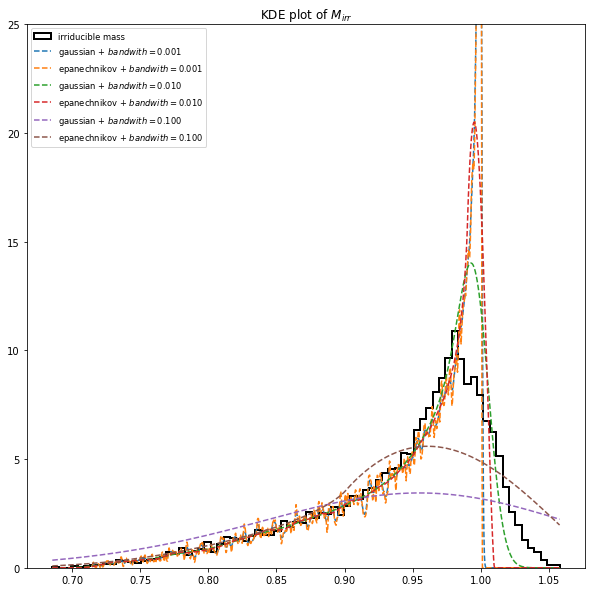

In [6]:
plt.figure(figsize=[10,10])
xgrid = np.linspace(M_irr(mass,chi).min(),M_irr(mass,chi).max(),1000)

plt.hist(M_irr(mass,chi),histtype="step", bins=80, lw=2, label='irriducible mass', color='black', density=True)

def kde_sklearn(data, bandwidth = 1.0, kernel="linear"):
    kde_skl = KernelDensity(bandwidth = bandwidth, 
                            kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)

bandwith=[0.001,0.01,0.1]


for k in (bandwith):
    plt.title('KDE plot of $M_{irr}$')
    PDFgauss = kde_sklearn(f,bandwidth=k,kernel="gaussian") # How do I set the best bandwith
    plt.plot(xgrid,PDFgauss, '--',label='gaussian + $bandwith = %1.3f$' % (k)) #Complete
    
    PDFepanechikov = kde_sklearn(f,bandwidth=k,kernel="epanechnikov") #Complete
    plt.plot(xgrid,PDFepanechikov,'--', label='epanechnikov + $bandwith = %1.3f$' % (k)) #Complete
    plt.legend(loc=0, fontsize='small')
    
plt.ylim(0,25)

M=mass


## Part 3 - limits

I perform the KS test on the required distributions to compare them. As we can see:

- For small $\sigma$, $M_{\rm irr}$ is distributed like $f$ (i.e. their KS distance goes to zero)
- For large $\sigma$, $M_{\rm irr}$ is distributed like $M$ (i.e. their KS distance goes to zero)

Look at the next cell for a more clear visualization.

Note:
    - ks_2samp = compare two samples (dataset)
    - ks_test = compares two distributions

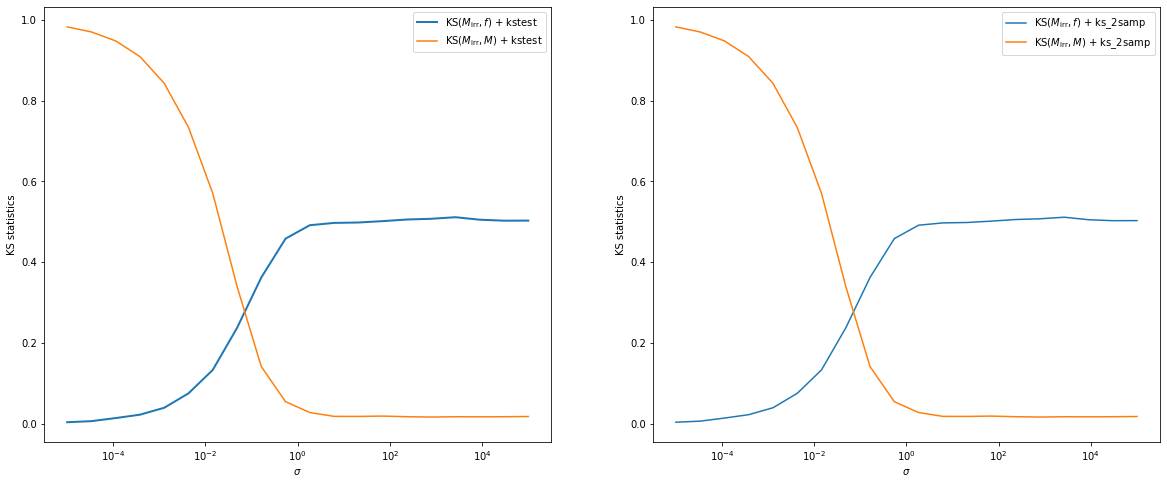

In [7]:
sigma=np.logspace(-5,5,20)

def M_irr(x,y):
    return x*np.sqrt((1+np.sqrt(1-y**2))/(2))

def f(x):
    return M_irr(mass,chi)/x



ks_test_m_f=[]
ks_test_m_mirr=[]
ks_test_m_f_2=[]
ks_test_m_mirr_2=[]


for j in range(len(sigma)):
    mass = np.random.normal(loc=1, scale=sigma[j], size=N)
    ks_test_m_f.append(stats.kstest(f(mass),M_irr(mass,chi))[0]) # I'm interestend on the statistics value and not on the p-value
    ks_test_m_mirr.append(stats.kstest(mass,M_irr(mass,chi))[0])
    
    ks_test_m_f_2.append(stats.ks_2samp(f(mass),M_irr(mass,chi))[0]) # I'm trying another ks statistics method
    ks_test_m_mirr_2.append(stats.ks_2samp(mass,M_irr(mass,chi))[0])
    
    
plt.figure(figsize=[20,8])  
plt.subplot(121)
plt.plot(sigma,ks_test_m_f, label='KS$(M_{\\rm irr}, f)$ + kstest', lw=2)
plt.plot(sigma,ks_test_m_mirr, label='KS$(M_{\\rm irr}, M)$ + kstest')
plt.ylabel('KS statistics')
plt.xlabel('$\sigma$')
plt.xscale('log')
plt.legend(loc=0)

plt.subplot(122)
plt.plot(sigma,ks_test_m_f_2, label='KS$(M_{\\rm irr}, f)$ + ks_2samp')
plt.plot(sigma,ks_test_m_mirr_2, label='KS$(M_{\\rm irr}, M)$ + ks_2samp')
plt.ylabel('KS statistics')
plt.xlabel('$\sigma$')
plt.xscale('log')
plt.legend(loc=0)


## Part 4 - PDF and double check on limits

I compute analitically the pdf of the irriducible mass (Hint 1 and 2), and than I plot it over the histograms of:
        - M
        - M_irr
        - f = M_irr/M
        
The pdf depends on sigma, than changing this scale parameter I can see how it is well desribe by a guassian (large sigma), cloesr to the M distribution at small sigma or even closer to f in the middle chociche.
        
        

  0%|          | 0/10000 [00:00<?, ?it/s]

0.02


  0%|          | 0/10000 [00:00<?, ?it/s]

0.1


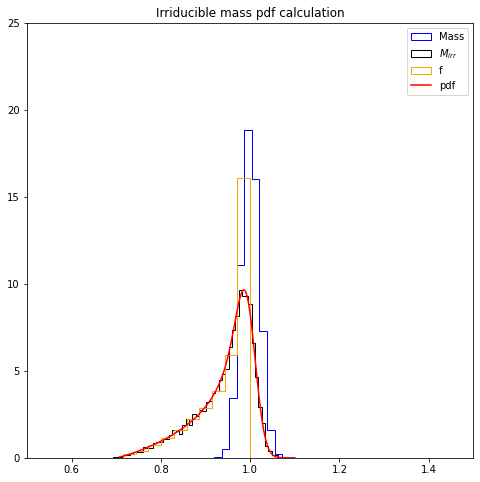

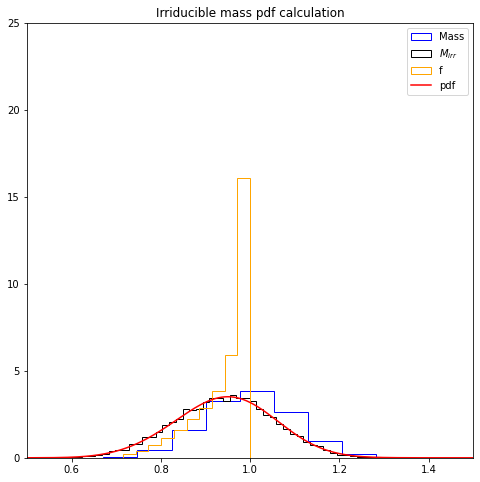

In [93]:
def limits(scale):
    
    M=np.random.normal(loc=1,scale=scale,size=N)
    plt.figure(figsize=[8,8])
    plt.title('Irriducible mass pdf calculation')
    plt.hist(M, density=True ,histtype='step',label='Mass', color='blue')
    plt.hist(M_irr(M,chi), bins=50, histtype='step', color='black', density=True, label='$M_{irr}$')
    plt.hist(M_irr(M,chi)/M, density=True, histtype='step', label='f',color='orange')
    
    
    x=np.linspace(min(1-5*scale,1/np.sqrt(2)),1+5*scale,N)
    
    
    def integrand(F,x):
        return (np.sqrt(2/np.pi) / scale ) * np.exp(-(x/F -1)**2 /(2*scale**2)) * (2*F**2-1)/(1 - F**2)**0.5 / F
    
    
    Mirr_pdf = [quad(lambda F: integrand(F,xt), 1/2**0.5,1)[0] for xt in tqdm(x)]
    
    plt.plot(x,Mirr_pdf,c='red',label='pdf')
    plt.xlim(0.5,1.5)
    plt.ylim(0,25)
    plt.legend(loc=0)
    
scales=[0.02,0.1]


for j in scales: 
    limits(j)
    print(j)
    